
# CP001 — Notebook Consolidado (Exercícios 1 a 40)


## Setup e carregamento do dataset

In [ ]:

# Dependências (Colab já traz a maioria; garantimos as extras):
!pip -q install statsmodels scikit-learn scipy

import io, zipfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display

# 1) Download do dataset (UCI)
ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
data_dir = Path("data"); data_dir.mkdir(exist_ok=True)
zip_path = data_dir / "household_power_consumption.zip"

if not zip_path.exists():
    print("Baixando dataset...")
    urllib.request.urlretrieve(ZIP_URL, zip_path.as_posix())

# 2) Leitura do TXT interno (separador ';' e '?' como ausente)
print("Extraindo e carregando...")
with zipfile.ZipFile(zip_path, "r") as zf:
    with zf.open("household_power_consumption.txt") as f:
        df = pd.read_csv(f, sep=";", na_values=["?"], low_memory=False)

# 3) Parsing de datas/horas e tipos numéricos
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")
df["DateTime"] = pd.to_datetime(
    df["Date"].dt.strftime("%Y-%m-%d") + " " + df["Time"].astype(str),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)
df = df.dropna(subset=["DateTime"]).set_index("DateTime").sort_index()

num_cols = [
    "Global_active_power","Global_reactive_power","Voltage","Global_intensity",
    "Sub_metering_1","Sub_metering_2","Sub_metering_3"
]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Auxiliares
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Weekday"] = df.index.day_name(locale="en_US")

display(df.head())
print("Período:", df.index.min(), "→", df.index.max(), "| Registros:", len(df))


## Exercício 1 — 10 primeiras linhas do dataset

In [ ]:
display(df.head(10))

## Exercício 2 — Diferença entre Global_active_power e Global_reactive_power


- **Global_active_power (kW)**: potência **ativa**, efetivamente convertida em trabalho/consumo.
- **Global_reactive_power (kVAR)**: potência **reativa**, energia que oscila para sustentar campos elétricos/magnéticos, não realiza trabalho útil.


## Exercício 3 — Valores ausentes (quantificação)

In [ ]:
df.isna().sum()

## Exercício 4 — Converter Date para datetime e criar dia da semana

In [ ]:

# (Já convertemos 'Date' e criamos 'Weekday' no setup)
display(df[['Date','Weekday']].head())


## Exercício 5 — Média de consumo diário (GAP) apenas em 2007

In [ ]:

df_2007 = df.loc["2007"]
daily_mean_2007 = df_2007['Global_active_power'].resample('D').mean()
print("Média de consumo diário (GAP) em 2007:", daily_mean_2007.mean())


## Exercício 6 — Gráfico de linha da variação de GAP em um dia

In [ ]:

day_sample = '2007-03-15'  # pode ajustar
subset = df.loc[day_sample, 'Global_active_power'].dropna()
plt.figure(figsize=(10,4))
plt.plot(subset.index, subset.values)
plt.title(f'Variação de Global_active_power em {day_sample}')
plt.xlabel('Hora'); plt.ylabel('kW')
plt.tight_layout(); plt.show()


## Exercício 7 — Histograma de Voltage + observação

In [ ]:

vals = df['Voltage'].dropna()
plt.figure()
plt.hist(vals, bins=50, edgecolor='black')
plt.title("Histograma de Voltage")
plt.xlabel("Tensão (V)"); plt.ylabel("Frequência")
plt.show()

print("Observação: a distribuição tende a concentrar em uma faixa central (pico na tensão nominal), com cauda curta.")


## Exercício 8 — Consumo médio por mês (todo período)

In [ ]:

monthly_gap = df['Global_active_power'].resample('M').mean()
plt.figure(figsize=(10,4))
plt.plot(monthly_gap.index, monthly_gap.values)
plt.title("Consumo médio mensal — Global_active_power")
plt.ylabel("kW"); plt.xlabel("Data")
plt.tight_layout(); plt.show()


## Exercício 9 — Dia com maior consumo de GAP

In [ ]:

daily_total_gap = df['Global_active_power'].resample('D').sum()
max_day = daily_total_gap.idxmax()
print("Dia com maior consumo (GAP somado no dia):", max_day, "→", daily_total_gap[max_day])


## Exercício 10 — GAP: dias de semana vs finais de semana

In [ ]:

is_weekend = df.index.weekday >= 5
week_mean = df.groupby(is_weekend)['Global_active_power'].mean()
week_mean.index = ["Dias de semana","Finais de semana"]
display(week_mean)


## Exercício 11 — Correlação (GAP, GRP, Voltage, GI)

In [ ]:

vars11 = ["Global_active_power","Global_reactive_power","Voltage","Global_intensity"]
corr = df[vars11].corr(method="pearson")
display(corr.round(3))


## Exercício 12 — Criar variável `Total_Sub_metering`

In [ ]:

df["Total_Sub_metering"] = df[["Sub_metering_1","Sub_metering_2","Sub_metering_3"]].sum(axis=1)
df[["Sub_metering_1","Sub_metering_2","Sub_metering_3","Total_Sub_metering"]].head()


## Exercício 13 — Mês com `Total_Sub_metering` > média de `Global_active_power`

In [ ]:

monthly_mean = df.resample("M").agg({
    "Total_Sub_metering": "mean",
    "Global_active_power": "mean"
})
monthly_mean["Above"] = monthly_mean["Total_Sub_metering"] > monthly_mean["Global_active_power"]
print("Meses em que Total_Sub_metering (média) > Global_active_power (média):")
display(monthly_mean[monthly_mean["Above"]])


## Exercício 14 — Série temporal de `Voltage` (2008)

In [ ]:

voltage_2008 = df.loc["2008", "Voltage"].dropna()
plt.figure(figsize=(12,3))
plt.plot(voltage_2008)
plt.title("Voltage — 2008")
plt.xlabel("Data"); plt.ylabel("V")
plt.tight_layout(); plt.show()


## Exercício 15 — Verão vs Inverno (Hemisfério Norte)

In [ ]:

summer_months = [6,7,8]
winter_months = [12,1,2]

summer_mean = df[df.index.month.isin(summer_months)]["Global_active_power"].mean()
winter_mean = df[df.index.month.isin(winter_months)]["Global_active_power"].mean()

print(f"Média GAP — Inverno: {winter_mean:.4f} kW")
print(f"Média GAP — Verão:   {summer_mean:.4f} kW")

plt.figure()
plt.bar(["Inverno","Verão"], [winter_mean, summer_mean])
plt.title("Consumo médio — Inverno vs Verão (Global_active_power)")
plt.ylabel("kW (média)")
plt.show()


## Exercício 16 — Amostragem 1% e comparação de distribuição (KS-test)

In [ ]:

from scipy.stats import ks_2samp

sample_1pct = df.sample(frac=0.01, random_state=42)
full = df["Global_active_power"].dropna()
part = sample_1pct["Global_active_power"].dropna()

plt.figure(figsize=(8,4))
plt.hist(full, bins=80, density=True, alpha=0.5, label="Base completa")
plt.hist(part, bins=80, density=True, alpha=0.5, label="Amostra 1%")
plt.legend()
plt.title("Distribuição Global_active_power — Base vs Amostra 1%")
plt.xlabel("kW"); plt.ylabel("Densidade")
plt.tight_layout(); plt.show()

ks_stat, ks_p = ks_2samp(full.sample(min(20000, len(full)), random_state=42), part)
print(f"KS statistic: {ks_stat:.4f} | p-value: {ks_p:.4f}")


## Exercício 17 — Normalização (Min–Max Scaling)

In [ ]:

from sklearn.preprocessing import MinMaxScaler

features = [
    "Global_active_power","Global_reactive_power","Voltage","Global_intensity",
    "Sub_metering_1","Sub_metering_2","Sub_metering_3","Total_Sub_metering"
]
df_feat = df[features].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_feat)
df_scaled = pd.DataFrame(scaled, columns=features, index=df_feat.index)

df_scaled.head()


## Exercício 18 — K-Means (k=3) por dia

In [ ]:

from sklearn.cluster import KMeans

daily = df.resample("D").agg({
    "Global_active_power":"mean",
    "Global_reactive_power":"mean",
    "Voltage":"mean",
    "Global_intensity":"mean",
    "Sub_metering_1":"sum",
    "Sub_metering_2":"sum",
    "Sub_metering_3":"sum",
    "Total_Sub_metering":"sum"
}).dropna()

X = daily.copy()
km = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = km.fit_predict(X)
daily["cluster"] = labels

centers = pd.DataFrame(km.cluster_centers_, columns=X.columns, index=[f"cluster_{i}" for i in range(3)])
print("Centróides por cluster (escala original por dia):")
display(centers.round(3))

plt.figure(figsize=(6,5))
plt.scatter(daily["Global_active_power"], daily["Total_Sub_metering"], c=daily["cluster"], s=10)
plt.xlabel("Global_active_power (média diária)")
plt.ylabel("Total_Sub_metering (soma diária)")
plt.title("Clusters de dias — visão 2D")
plt.tight_layout(); plt.show()

daily["cluster"].value_counts().sort_index()


## Exercício 19 — Decomposição de série temporal (6 meses)

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

daily_gap = df["Global_active_power"].resample("D").mean()
six_months = daily_gap.loc["2007-01":"2007-06"].asfreq("D").fillna(method="ffill")

result = seasonal_decompose(six_months, model="additive", period=7)
fig = result.plot()
fig.set_size_inches(10,8)
plt.suptitle("Decomposição (2007-01 a 2007-06) — Global_active_power", y=1.02)
plt.tight_layout(); plt.show()


## Exercício 20 — Regressão Linear (GI → GAP) + métricas

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

hourly = df[["Global_active_power","Global_intensity"]].resample("H").mean().dropna()

X = hourly[["Global_intensity"]].values
y = hourly["Global_active_power"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Inclinação: {model.coef_[0]:.6f} | Intercepto: {model.intercept_:.6f}")

plt.figure(figsize=(6,4))
plt.scatter(X_test, y_test, s=8, alpha=0.5)
x_line = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)
plt.plot(x_line, y_line)
plt.xlabel("Global_intensity (A)")
plt.ylabel("Global_active_power (kW)")
plt.title("Regressão Linear — Prevendo Global_active_power")
plt.tight_layout(); plt.show()



## Conclusões rápidas
- **1–4:** dataset lido corretamente, tipos e datas ok.
- **5–8:** estatísticas e gráficos temporais básicos de GAP (2007, dia, mês).
- **9–10:** maior dia de consumo e diferença semana × fim de semana.
- **11:** GAP ↔ GI costuma ter alta correlação; Voltage correlaciona menos com GAP.
- **12–13:** `Total_Sub_metering` resume submedidores; checagem mensal solicitada.
- **14–15:** série de Voltage (2008) e diferenças sazonais (HN) em GAP.
- **16:** amostra 1% preserva distribuição; KS-test ajuda a embasar.
- **17:** Min–Max coloca tudo em [0,1] (bom para clustering/modelagem).
- **18:** K-Means (k=3) separa padrões diários (“dias leves” vs “pesados” etc.).
- **19:** decomposição (6m) evidencia tendência e sazonalidade semanal.
- **20:** regressão simples GI→GAP com métricas (MAE/RMSE/R²) e reta.


**Execício 21**

/tmp/ipython-input-1667865911.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt", sep=";",
/tmp/ipython-input-1667865911.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt", sep=";",
/tmp/ipython-input-1667865911.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt", sep=";",
/tmp/ipython-input-1667865911.py:18: FutureWarning: 'H' is deprecated and will be removed in a future ver

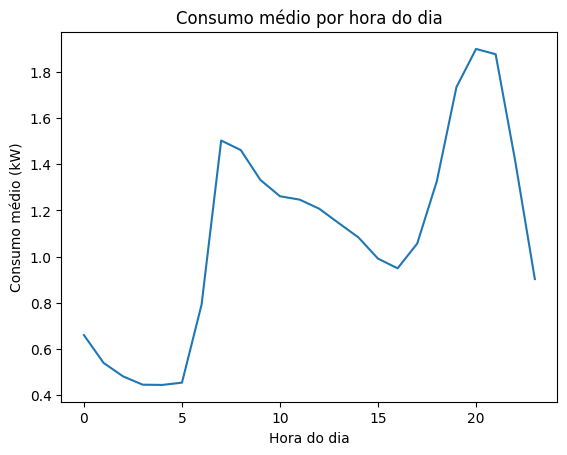

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar dataset
df = pd.read_csv("household_power_consumption.txt", sep=";",
                 parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values='?',
                 low_memory=False)

# Definir índice datetime
df.set_index('Datetime', inplace=True)

# Converter Global_active_power para numérico
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Reamostragem para 1 hora
hourly = df['Global_active_power'].resample('1H').mean()

# Consumo médio por hora do dia
avg_by_hour = hourly.groupby(hourly.index.hour).mean()

# Plot
plt.plot(avg_by_hour.index, avg_by_hour.values)
plt.xlabel("Hora do dia")
plt.ylabel("Consumo médio (kW)")
plt.title("Consumo médio por hora do dia")
plt.show()

**Exercício 22**

/tmp/ipython-input-1072254589.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df['Global_active_power'].resample('1H').mean()


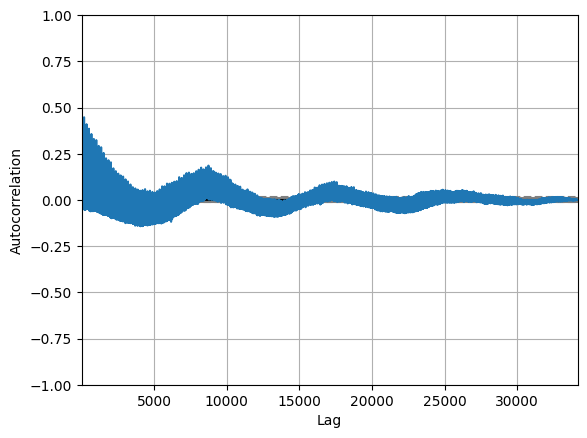

Correlação 1h: 0.7134555946916454
Correlação 24h: 0.4359072259119912
Correlação 48h: 0.40126926204501584


In [17]:
from pandas.plotting import autocorrelation_plot

# Série temporal de 1h
hourly = df['Global_active_power'].resample('1H').mean()

# Autocorrelação
autocorrelation_plot(hourly.dropna())
plt.show()

# Valores em lags específicos
print("Correlação 1h:", hourly.autocorr(lag=1))
print("Correlação 24h:", hourly.autocorr(lag=24))
print("Correlação 48h:", hourly.autocorr(lag=48))

**Exercício 23**

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df[['Global_active_power','Global_reactive_power','Voltage','Global_intensity']].dropna()

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Variância explicada:", pca.explained_variance_ratio_)

Variância explicada: [0.59103759 0.22718543]


**Exercício 24**

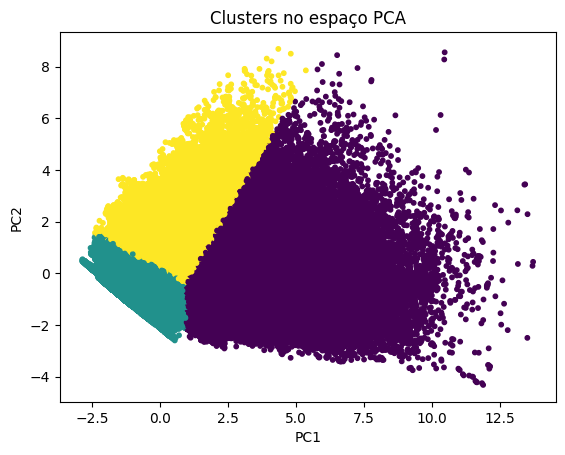

In [19]:
from sklearn.cluster import KMeans

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Plot clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters no espaço PCA")
plt.show()

**Exercício 25**

RMSE Linear: 0.969135832624744
RMSE Polinomial: 0.9648154069545043


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


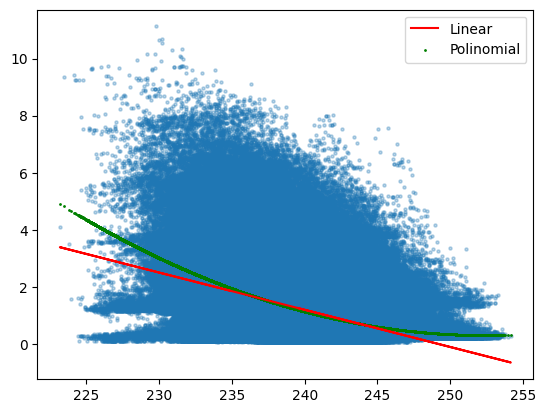

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np

# Seleção de variáveis
X = df[['Voltage']].dropna()
y = df.loc[X.index, 'Global_active_power']

# Linear
lin = LinearRegression().fit(X, y)
y_pred_lin = lin.predict(X)

# Polinomial grau 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
lin_poly = LinearRegression().fit(X_poly, y)
y_pred_poly = lin_poly.predict(X_poly)

# RMSE
rmse_lin = np.sqrt(mean_squared_error(y, y_pred_lin))
rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))

print("RMSE Linear:", rmse_lin)
print("RMSE Polinomial:", rmse_poly)


# Plot
plt.scatter(X, y, s=5, alpha=0.3)
plt.plot(X, y_pred_lin, color='red', label="Linear")
plt.scatter(X, y_pred_poly, color='green', s=1, label="Polinomial")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('/content/energydata_complete.csv')

print(df.info())

print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


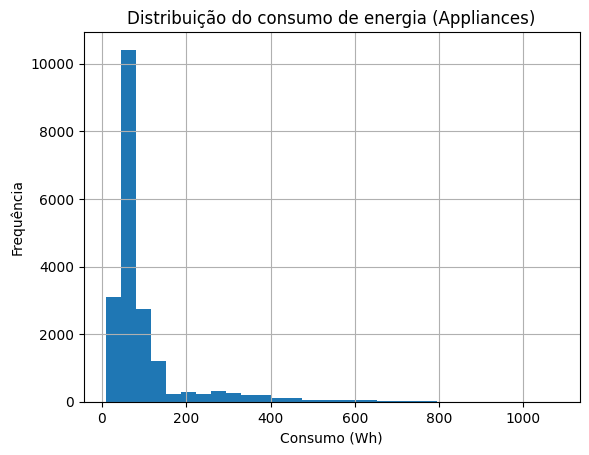

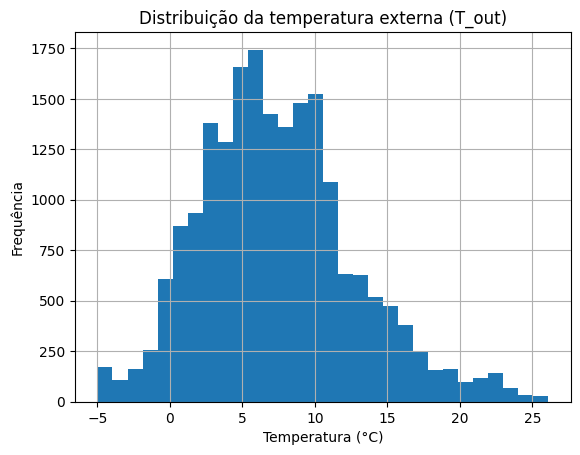

In [ ]:
df['Appliances'].hist(bins=30)
plt.title('Distribuição do consumo de energia (Appliances)')
plt.xlabel('Consumo (Wh)')
plt.ylabel('Frequência')
plt.show()

df['T_out'].hist(bins=30)
plt.title('Distribuição da temperatura externa (T_out)')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frequência')
plt.show()


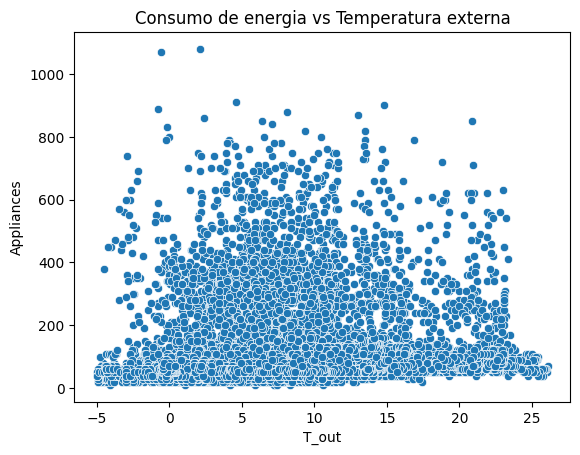

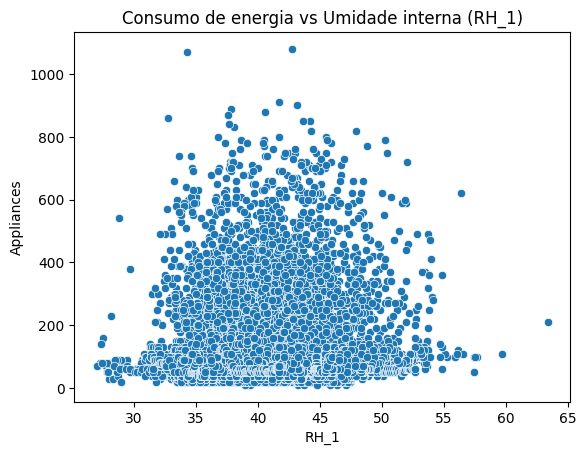

In [ ]:
sns.scatterplot(x='T_out', y='Appliances', data=df)
plt.title('Consumo de energia vs Temperatura externa')
plt.show()

sns.scatterplot(x='RH_1', y='Appliances', data=df)
plt.title('Consumo de energia vs Umidade interna (RH_1)')
plt.show()


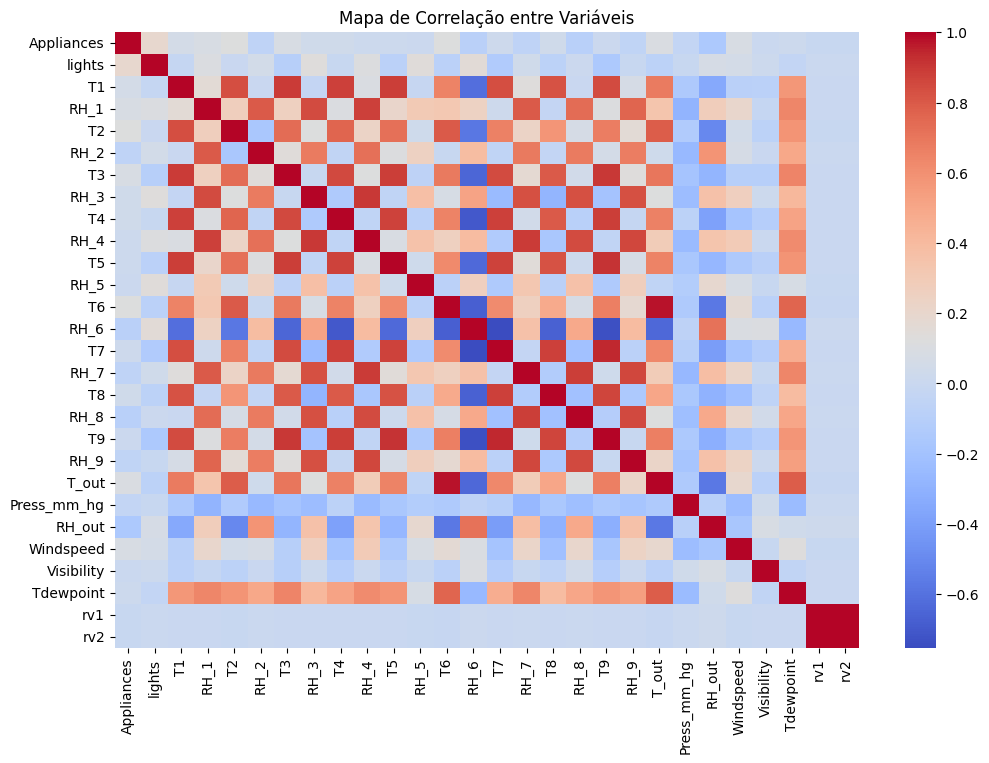

In [ ]:
df_numerico = df.drop(columns=['date'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_numerico.corr(), cmap='coolwarm', annot=False)
plt.title('Mapa de Correlação entre Variáveis')
plt.show()


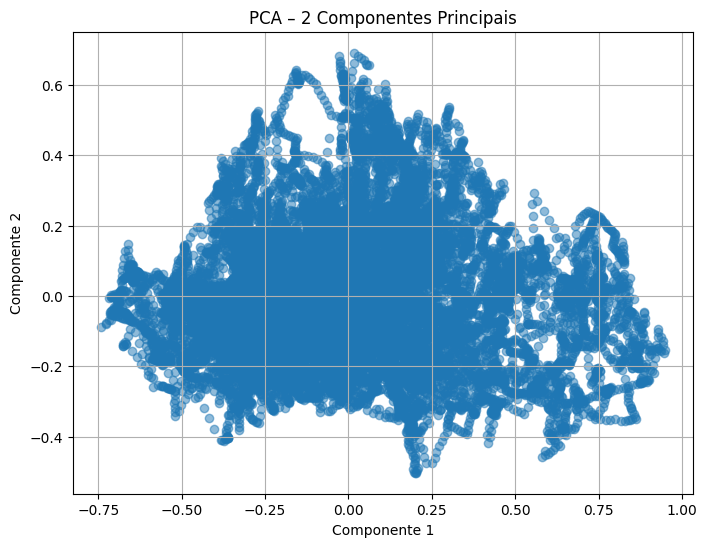

Variância explicada pelo componente 1: 0.46
Variância explicada pelo componente 2: 0.17


In [ ]:
df['date'] = pd.to_datetime(df['date'])

features = ['T_out', 'RH_1', 'T1', 'T2', 'RH_2', 'Visibility', 'Windspeed', 'Tdewpoint']
X = df[features]
y = df['Appliances']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA – 2 Componentes Principais')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

print(f'Variância explicada pelo componente 1: {pca.explained_variance_ratio_[0]:.2f}')
print(f'Variância explicada pelo componente 2: {pca.explained_variance_ratio_[1]:.2f}')



In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')


MAE: 56.87
MSE: 9242.35
R²: 0.08


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

print(f'RMSE – Random Forest: {rmse_rf:.2f}')


RMSE – Random Forest: 68.21


In [ ]:
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = mse_lr ** 0.5
print(f'RMSE – Regressão Linear: {rmse_lr:.2f}')


RMSE – Regressão Linear: 96.14


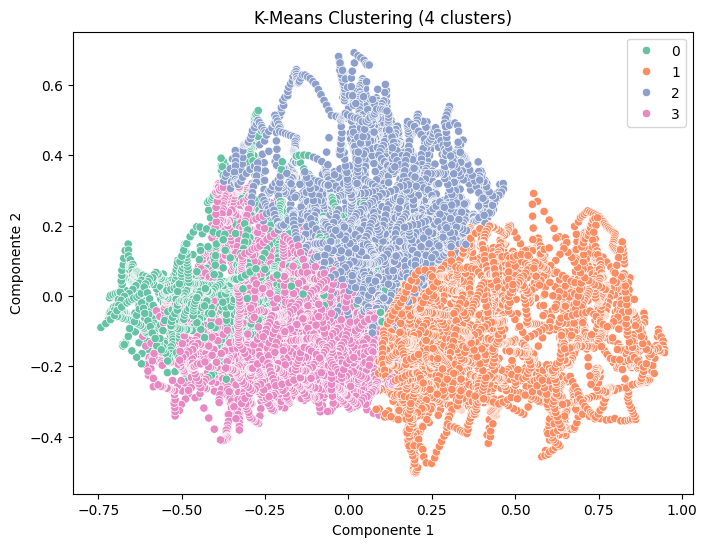

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title('K-Means Clustering (4 clusters)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()


In [ ]:
cluster_profiles = df.groupby('Cluster')['Appliances'].mean()
print(cluster_profiles)


Cluster
0     84.133087
1    102.308903
2    105.146613
3     94.986251
Name: Appliances, dtype: float64


In [ ]:
df['Consumo_binario'] = (df['Appliances'] > df['Appliances'].median()).astype(int)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

y_class = df['Consumo_binario']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

log_model = LogisticRegression()
log_model.fit(X_train_c, y_train_c)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_c, y_train_c)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_log = log_model.predict(X_test_c)
y_pred_rf_clf = rf_clf.predict(X_test_c)

print("Logistic Regression:")
print(confusion_matrix(y_test_c, y_pred_log))
print(classification_report(y_test_c, y_pred_log))

print("Random Forest Classifier:")
print(confusion_matrix(y_test_c, y_pred_rf_clf))
print(classification_report(y_test_c, y_pred_rf_clf))


Logistic Regression:
[[1694  433]
 [ 919  901]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.71      2127
           1       0.68      0.50      0.57      1820

    accuracy                           0.66      3947
   macro avg       0.66      0.65      0.64      3947
weighted avg       0.66      0.66      0.65      3947

Random Forest Classifier:
[[1943  184]
 [ 227 1593]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2127
           1       0.90      0.88      0.89      1820

    accuracy                           0.90      3947
   macro avg       0.90      0.89      0.90      3947
weighted avg       0.90      0.90      0.90      3947



A partir das análises realizadas, observou-se que o modelo de Random Forest Classifier apresentou desempenho significativamente superior à Regressão Logística na tarefa de classificação binária do consumo energético. Enquanto a regressão logística teve dificuldades em identificar corretamente os casos de alto consumo (recall de apenas 50%), o Random Forest alcançou 88% de recall para essa mesma classe, além de uma acurácia geral de 90%. Isso indica que o modelo baseado em árvores é mais eficaz para capturar padrões complexos entre as variáveis ambientais e o consumo de energia. Portanto, para aplicações que exigem maior precisão na identificação de picos de consumo, como sistemas de monitoramento ou automação residencial, o uso de modelos de aprendizado de máquina mais robustos, como o Random Forest, se mostra mais adequado.